# Laboratorio de Datos 1ercuat 2022

## Clasificacion de Textos - Train

### Original - GUardar y Hacer Copia para trabajar - Estado al 30/05/2022

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from io import StringIO
import os
import re
import matplotlib.pyplot as plt
import pickle

from time import time

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import sklearn as sk

from collections import Counter

pd.set_option('display.max_columns', False)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

debug = True

limite_de_palabras = 20
out_path = os.getcwd() + '\\word_count_' + str(limite_de_palabras) + '\\'
os.mkdir(out_path)

In [2]:
df_clases = '002_Text_Classification_clases.csv'
id_clases_df = pd.read_csv(df_clases)[0:8]
id_clases_df.drop(columns=['clase'], inplace = True )
clase_a_id = dict(id_clases_df.values)
id_a_clase = dict(id_clases_df[['id_clase','clase_original']].values)

In [3]:
df_train_file = '002_Text_train_final_sin_numeros.csv'
df_a_procesar = pd.read_csv(df_train_file)
print(df_a_procesar.shape)
df_a_procesar.head(10)

(3709, 6)


,clase_original,texto_original,texto_etl,texto_corregido,id_clase,nro_palabras
0,no_identificada,se normalizo medidor lindero XXXXXXX estado XXXXX/XXXXX cambiando tapa y acometida.,normalizo medidor lindero estado cambiando tapa acometida,se normalizo medidor lindero estado cambiando tapa y acometida,7,7
1,ok_equipo,se realizo verificacion completa se coloco caja antihurto se cambio pipeta rota energia activa: XXXXX energia reactiva: XXXXXX,realizo verificacion completa coloco caja antihurto cambio pipeta rota energia activa energia reactiva,se realizo verificacion completa se coloco caja antihurto se cambio pipeta rota energia activa energia reactiva,6,13
2,intrusion,se corto conexion directa sin medidor. en pje XXX camino Y XXXX,corto conexion directo sin medidor pje camino Y,se corto conexion directa sin medidor en pje camino Y,0,8
3,no_identificada,se cambio medidor monofasico y normaliza.,cambio medidor monofasico normalizo,se cambio medidor monofasico y normaliza,7,4
4,intrusion,se retira conexion clandestina se normaliza suministro.,retira conexion clandestina normalizo suministro,se retira conexion clandestina se normaliza suministro,0,5
5,intrusion,numerador manipulado se cambia medidor.,numerador manipulado cambio medidor,numerador manipulado se cambia medidor,0,4
6,reparacion,cambio de medidor monofasico golpeado con visor roto y tapa monofasica obsoleta.,cambio medidor monofasico golpeado con visor roto tapa monofasica obsoleta,cambio de medidor monofasico golpeado con visor roto y tapa monofasica obsoleta,1,10
7,intrusion,medidor manipulado fase y neutro invertidos la fase ingresaba por bornera de neutro y el neutro por bornera de fase se normalizo.,medidor manipulado fase neutro invertidos fase ingresaba bornera neutro neutro bornera fase normalizo,medidor manipulado fase y neutro invertidos la fase ingresaba por bornera de neutro y el neutro por bornera de fase se normalizo,0,13
8,reparacion,se encontro medidor quemado en bornera. se normaliza colocando medidor numero XXXXXXX. se realiza inspeccion completa y se coloca tapa capilla chica. se dejo presintado.,encontro medidor quemado bornera normalizo colocando medidor numero realizo inspeccion completa coloca tapa capilla chica dejo presintado,se encontro medidor quemado en bornera se normaliza colocando medidor numero se realiza inspeccion completa y se coloca tapa capilla chica se dejo presintado,1,17
9,intrusion,Se Quitó Fraude Fase X Fase. Se Normalizó El Servicio. Se Realiza Acta De Fraude.,quito fraude fase fase normalizo servicio realizo acta fraude,se quito fraude fase por fase se normalizo el servicio se realiza acta de fraude,0,9


In [4]:
print('Control de valores nulos\n-------------------------')
print('clase_original\t', df_a_procesar['clase_original'].isnull().values.any())
print('texto_original\t',df_a_procesar['texto_original'].isnull().values.any())
print('texto_etl\t',df_a_procesar['texto_etl'].isnull().values.any())
print('texto_corregido\t',df_a_procesar['texto_corregido'].isnull().values.any())
print('id_clase\t',df_a_procesar['id_clase'].isnull().values.any())
print('nro_palabras\t',df_a_procesar['nro_palabras'].isnull().values.any())

Control de valores nulos
-------------------------
clase_original	 False
texto_original	 False
texto_etl	 False
texto_corregido	 False
id_clase	 False
nro_palabras	 False


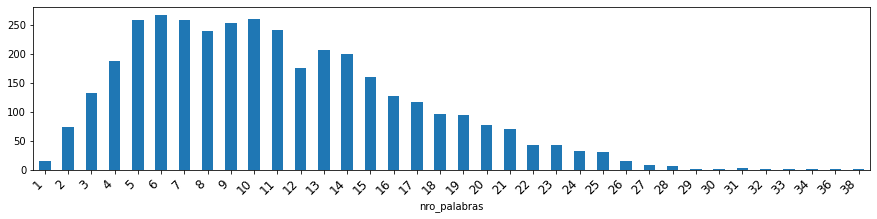

In [5]:
# Histograma del número de palabras
fig = plt.figure(figsize=(15,3))
df_a_procesar.groupby('nro_palabras').texto_original.count().plot.bar(ylim=0)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show();

In [6]:
# Seleccion limitando la cantidad de palabras
df_a_procesar = df_a_procesar[df_a_procesar['nro_palabras']<=limite_de_palabras]
print(df_a_procesar.shape)

(3446, 6)


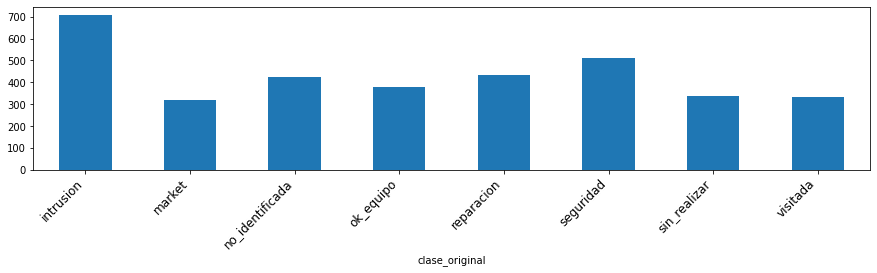

In [7]:
# Cantidad de textos por clase original
fig = plt.figure(figsize=(15,3))
df_a_procesar.groupby('clase_original').texto_original.count().plot.bar(ylim=0)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.show()

In [8]:
df_a_procesar.groupby('clase_original').texto_original.count().sort_values(ascending=False) 

df_a_procesar['clase_original'].value_counts().to_csv(out_path + 'df_value_counts_nro_palabras_' + str(limite_de_palabras) + '.csv')

# Proceso con modelo tfidf

## Seleccion de caracteristicas

In [9]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 4)) #, stop_words=stop_words_spanish)
features = tfidf.fit_transform(df_a_procesar.texto_etl)
features = features.toarray()
labels = df_a_procesar.id_clase

pickle.dump(features, open('030_train_tfidf_features.pkl', 'wb'))
pickle.dump(features, open('030_train_tfidf.pkl', 'wb'))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df_a_procesar['texto_etl'], df_a_procesar['clase_original'], test_size=0.25, random_state = 0, stratify=df_a_procesar['clase_original'])
print('X_train shape =',X_train.shape,'\tY_train shape =',y_train.shape)
print('X_test  shape =',X_test.shape,'\tY_test  shape =',y_test.shape)
print(y_train)

X_train shape = (2584,) 	Y_train shape = (2584,)
X_test  shape = (862,) 	Y_test  shape = (862,)
2633    no_identificada
2567    seguridad      
3121    market         
2798    ok_equipo      
1187    intrusion      
          ...          
3334    no_identificada
245     no_identificada
3456    visitada       
721     ok_equipo      
2394    seguridad      
Name: clase_original, Length: 2584, dtype: object


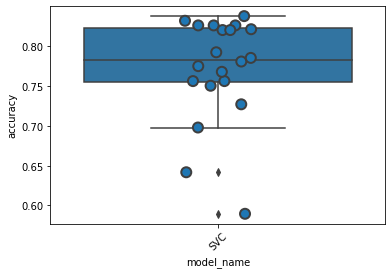

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

models = [
    SVC(kernel = 'rbf', random_state = 0),
    #LinearSVC(),
    #LogisticRegression(),
    #MultinomialNB(),
    #SGDClassifier(),
    #CalibratedClassifierCV()
    #RandomForestClassifier(n_estimators=500, max_depth=3, random_state=0),
    #GradientBoostingClassifier(n_estimators=500, learning_rate=1.0,max_depth=3, random_state=0)
]
CV = 20
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.show()

In [12]:
f = open(out_path + 'model_accuracy.txt', 'w')
f.write(str(cv_df.groupby('model_name').accuracy.mean()))
f.write('\n')
f.write(str(cv_df.groupby('model_name').accuracy.std()))
f.close()

print(cv_df.groupby('model_name').accuracy.mean())
print(cv_df.groupby('model_name').accuracy.std())

model_name
SVC    0.771105
Name: accuracy, dtype: float64
model_name
SVC    0.066028
Name: accuracy, dtype: float64



## Grid Search

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df_a_procesar.index, test_size=0.25, random_state=0, stratify=df_a_procesar['id_clase'])

model_linear_svc = LinearSVC()

model_linear_rbf = SVC(kernel = 'rbf', random_state = 0)

print(df_a_procesar.shape)
print(X_train.shape)

(3446, 6)
(2584, 2322)


In [14]:
# Grid Search para LinearSVC
params = {'max_iter': [5,10,15,20,25,30,40,50,60,70,80,100], 'penalty': ['l1', 'l2'], 'loss': ['hinge', 'squared_hinge']}
Grid_Search_LinearSVC = GridSearchCV(model_linear_svc, params, scoring='accuracy', cv=25)
Grid_Search_LinearSVC.fit(X_train, y_train)

model_linear_svc.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [15]:
# Grid Search para Radial Kernel SVC
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on development set:

0.026 (+/-0.000) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.026 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.026 (+/-0.000) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.026 (+/-0.000) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.772 (+/-0.031) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.026 (+/-0.000) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.754 (+/-0.038) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.772 (+/-0.032) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.770 (+/-0.051) for {'C': 1, 'kernel': 'linear'}
0.736 (+/-0.032) for {'C': 10, 'kernel': 'linear'}
0.734 (+/-0.031) for {'C': 100, 'kernel': 'linear'}
0.735 (+/-0.032) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are compute

In [16]:
f = open(out_path + 'model_best_params.txt', 'w')
f.write(str(model_linear_svc.get_params()))
f.write('\n')
f.write("El mejor score es:")
f.write(str(Grid_Search_LinearSVC.best_score_))
f.write('\n')
f.write("Los mejores parámetros son:")
f.write(str(Grid_Search_LinearSVC.best_params_))
f.close()

print("El mejor score es:")
print(Grid_Search_LinearSVC.best_score_)
print("Los mejores parámetros son:")
print(Grid_Search_LinearSVC.best_params_)

El mejor score es:
0.7852277819268112
Los mejores parámetros son:
{'loss': 'hinge', 'max_iter': 15, 'penalty': 'l2'}


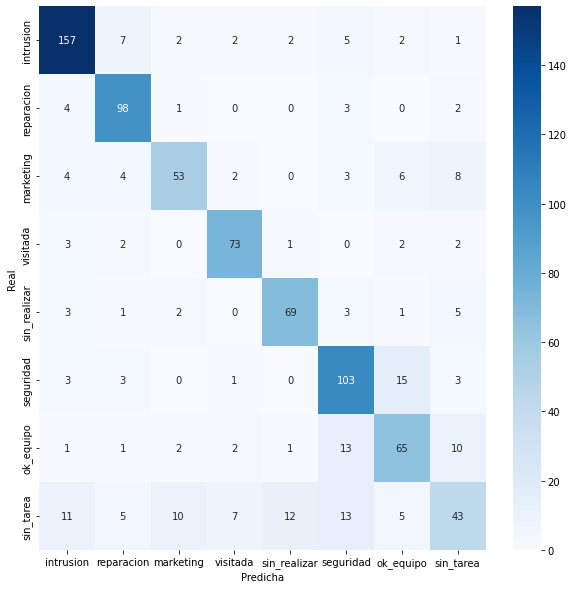

In [17]:
#model = SGDClassifier()
Best_Params_LinearSVC = Grid_Search_LinearSVC.best_estimator_
model = Best_Params_LinearSVC
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=0, stratify=df['category_id'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues",
            xticklabels=id_clases_df['clase_original'].values, yticklabels=id_clases_df['clase_original'].values)
plt.ylabel('Real')
plt.xlabel('Predicha')
plt.savefig(out_path + 'heatmap.jpg')
plt.show()

In [18]:
df_confusion = pd.crosstab(y_test, y_pred)
df_confusion.to_csv(out_path + '030_Text_matriz_confusion.csv', index=False)

In [19]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df_a_procesar['clase_original'].unique()))

                 precision    recall  f1-score   support

no_identificada       0.84      0.88      0.86       178
      ok_equipo       0.81      0.91      0.86       108
      intrusion       0.76      0.66      0.71        80
     reparacion       0.84      0.88      0.86        83
         market       0.81      0.82      0.82        84
      seguridad       0.72      0.80      0.76       128
       visitada       0.68      0.68      0.68        95
   sin_realizar       0.58      0.41      0.48       106

       accuracy                           0.77       862
      macro avg       0.76      0.76      0.75       862
   weighted avg       0.76      0.77      0.76       862



In [20]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(model) 
clf.fit(X_train, y_train)


key= '030_adv-Text_linear_svc_bp_prob.pkl'

pickle_byte_obj = pickle.dumps(clf)


In [21]:
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [22]:
report_with_auc = class_report(
    y_true=y_test, 
    y_pred=model.predict(X_test), 
    y_score=clf.predict_proba(X_test))

print(report_with_auc)
report_with_auc.to_csv(out_path + 'report_with_auc.csv')

             precision    recall  f1-score  support   pred       AUC
0            0.844086   0.882022  0.862637  178.0    186.0  0.979327
1            0.809917   0.907407  0.855895  108.0    121.0  0.978534
2            0.757143   0.662500  0.706667  80.0     70.0   0.935902
3            0.839080   0.879518  0.858824  83.0     87.0   0.992452
4            0.811765   0.821429  0.816568  84.0     85.0   0.975073
5            0.720280   0.804688  0.760148  128.0    143.0  0.964317
6            0.677083   0.684211  0.680628  95.0     96.0   0.940355
7            0.581081   0.405660  0.477778  106.0    74.0   0.802679
avg / total  0.758973   0.766821  0.759857  862.0    862.0  0.958889


In [23]:
## Probabilidades con CalibratedClassifier

## https://medium.com/@manoveg/multi-class-text-classification-with-probability-prediction-for-each-class-using-linearsvc-in-289189fbb100

## Interpretacion del modelo nlp

### https://medium.com/@kalia_65609/interpreting-an-nlp-model-with-lime-and-shap-834ccfa124e4

### https://towardsdatascience.com/explain-nlp-models-with-lime-shap-5c5a9f84d59b

## Bayes

### https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34